In [77]:
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        
        self.tanh = nn.Tanh()
        
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l1.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l1.weight)

        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l2.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l2.weight)

        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l3.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l3.weight)

        self.l4 = nn.Linear(hidden_size, output_size)
        self.l4.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l4.weight)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        return out

In [132]:
K = 40
r = 0.05
sigma = 0.15
T = [0.0, 1.0]
S = [0, 160]
t_sample_size = 101
S_sample_size = 101

In [138]:
pinn = NN(2, 16, 1)
pinn.to(device)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.01)

t_samples = torch.linspace(T[0], T[1], t_sample_size)
S_samples = torch.linspace(S[0], S[1], S_sample_size)

# Boundary: C(0,t) = 0
boundary1 = torch.stack((torch.full((t_sample_size,), S[0]), t_samples), dim=1).requires_grad_(True)
# Bourdary: C(S->inf,t) = S-Ke^-r(T-t)
boundary2 = torch.stack((torch.full((t_sample_size,), S[1]), t_samples), dim=1).requires_grad_(True)
# Boundary: C(S,T) = max(S-K, 0)
boundary3 = torch.stack((S_samples, torch.full((S_sample_size,), T[1])), dim=1).requires_grad_(True)

# Mesh (S,t)
mesh = torch.cartesian_prod(S_samples, t_samples).requires_grad_(True)

for i in range(1000):
    optimizer.zero_grad()

    u = pinn(boundary1)
    loss_boundary1 = torch.squeeze(u).pow(2)
    
    u = pinn(boundary2)
    S_inf = S[1] - K * torch.exp(-r * (T[1] - t_samples))
    loss_boundary2 = (torch.squeeze(u) - S_inf).pow(2)

    u = pinn(boundary3)
    loss_boundary3 = (torch.squeeze(u) - torch.max(S_samples-K, 0)).pow(2)

    boudary_loss = loss_boundary1 + loss_boundary2 + loss_boundary3

    boudary_loss.backward()

    optimizer.step()

TypeError: unsupported operand type(s) for -: 'Tensor' and 'torch.return_types.max'

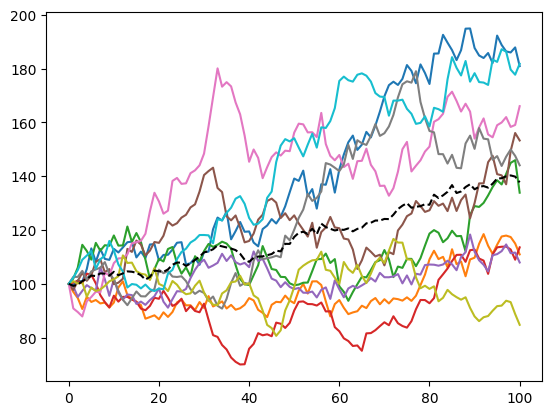

In [127]:
 mu = 0.02
n = 100
dt = 0.1
x0 = 100

sigma = np.full(10, 0.1)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.plot([np.average(av) for av in x], 'k--')
plt.show()

(array([   0.,    0.,    0.,    0.,    0., 1019.,    0.,    0.,    0.,
           0.]),
 array([299.85, 299.95, 300.05, 300.15, 300.25, 300.35, 300.45, 300.55,
        300.65, 300.75, 300.85]),
 <BarContainer object of 10 artists>)

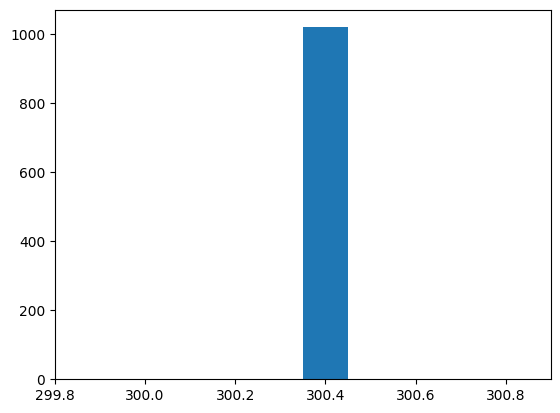

In [125]:
df = pd.read_csv('aapl_eod_202001.csv', sep=r'\s*,\s*', engine='python')
# plt.plot(df.sort_values(by='[QUOTE_UNIXTIME]')['[QUOTE_UNIXTIME]'], df.sort_values(by='[QUOTE_UNIXTIME]')['[UNDERLYING_LAST]'])
dat = df[df['[QUOTE_DATE]'] == '2020-01-02']
plt.hist(dat['[UNDERLYING_LAST]'])